# SETUP

**IMPORTANT NOTE:**
- Go to "Edit" -> "Notebook setting" and set:
  - Runtime type: Python 3
  - Hardware accelerator: GPU

**Mount data from Google Drive**
- Run cells. `GDRIVE_ROOT` is where Google Drive will be mounted
- Click the URL displayed to get authorization code (login and allow access google drive account if required)
- Copy authorization code, back to this file and paste to the input below "Enter your authorization code:" then hit Enter

In [0]:
GDRIVE_ROOT = '/content/gdrive'
# NOTE: change trainer to current trainer
trainer = 'Vinh'

In [0]:
from google.colab import drive
drive.mount(GDRIVE_ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -r triplet-cnn-cbir
!git clone https://github.com/VictorNM/triplet-cnn-cbir.git

rm: cannot remove 'triplet-cnn-cbir': No such file or directory
Cloning into 'triplet-cnn-cbir'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 821 (delta 175), reused 221 (delta 112), pack-reused 534
Receiving objects: 100% (821/821), 40.87 MiB | 37.50 MiB/s, done.
Resolving deltas: 100% (466/466), done.


In [0]:
import sys
sys.path.append('triplet-cnn-cbir')

# import all dependencies
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import SGD

import os
import numpy as np

from src import data, models, visualization, utils, callbacks, experiment

Using TensorFlow backend.


In [0]:
# config folder
DISSERTATION_DIR = os.path.join(GDRIVE_ROOT, 'My Drive/bku-dissertation')
print('Dissetation directory:', DISSERTATION_DIR)

Dissetation directory: /content/gdrive/My Drive/bku-dissertation


# RUN

## Prepare

### Load and process data

In [0]:
DATA_ROOT = os.path.join(DISSERTATION_DIR, 'data')
dataset_name = '_2_fan_kettle_600_200_200'
dataset_type = 'raw'
input_size = (224, 224)

train_path = os.path.join(DATA_ROOT, dataset_type, dataset_name, 'train')
train_generator = ImageDataGenerator(rescale=1./255) \
                  .flow_from_directory(train_path, input_size)

valid_path = os.path.join(DATA_ROOT, dataset_type, dataset_name, 'valid')
valid_generator = ImageDataGenerator(rescale=1./255) \
                  .flow_from_directory(valid_path, input_size)

# get name of classes
classes = [[] for i in range(train_generator.num_classes)]
for k, v in train_generator.class_indices.items():
  classes[v] = k
  
print('Classes:', classes)

Found 1200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Classes: ['fan', 'kettle']


In [0]:
# get all valid dataset for visualize on tensorboard
x_valid, y_valid = data.convert_generator_to_data(valid_generator)
print(x_valid.shape, y_valid.shape)

(400, 224, 224, 3) (400,)


### Prepare TensorBoard

In [0]:
LOGS_DIR = '/content/logs'
print(callbacks.get_tensorboard_url(LOGS_DIR))

https://92782e60.ngrok.io


## Train CNN

### Build CNN

In [0]:
def build_cnn_classifier(input_shape, num_classes):
  cnn = Sequential()

  cnn.add(Conv2D(64, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape))
  cnn.add(Activation('relu'))
  cnn.add(MaxPooling2D((2, 2), strides=(2, 2)))

  cnn.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1'))
  cnn.add(Activation('relu'))
  cnn.add(MaxPooling2D((2, 2), strides=(2, 2)))

  cnn.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1'))
  cnn.add(Activation('relu'))
  cnn.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2'))
  cnn.add(Activation('relu'))
  cnn.add(MaxPooling2D((2, 2), strides=(2, 2)))

  cnn.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1'))
  cnn.add(Activation('relu'))
  cnn.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2'))
  cnn.add(Activation('relu'))
  cnn.add(MaxPooling2D((2, 2), strides=(2, 2)))

  cnn.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1'))
  cnn.add(Activation('relu'))
  cnn.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2'))
  cnn.add(Activation('relu'))
  cnn.add(MaxPooling2D((2, 2), strides=(2, 2)))
  cnn.add(Dropout(0.5))  

  cnn.add(Flatten())
  cnn.add(Dense(4096, activation='relu', name='fc1'))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(4096, activation='relu', name='fc2'))
  cnn.add(Dense(num_classes, activation='softmax', name='predictions'))

  return cnn

num_classes = len(classes)
input_shape = train_generator.image_shape
cnn_classifier = build_cnn_classifier(input_shape, num_classes)
cnn_classifier.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxP

### Train CNN

In [0]:
# compile model
optimizer_params = {
    "lr": 0.001,
    "momentum": 0.9
}
opt = SGD(**optimizer_params)

cnn_classifier.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [0]:
# get datetime train for files name (logs, model...)
datetime_train = utils.get_datetime_train()
print('Datetime train:', datetime_train)

# Tensor board
tensorboard_params = {
    "histogram_freq": 0,
    "write_graph": True,
    "embeddings_freq": 1    # NOTE: must provide value >= 1 for visualize embedding
}
tensorboard = callbacks.get_tensorboard(
    logs_dir=LOGS_DIR,
    datetime_train=datetime_train, 
    x=x_valid, 
    y=y_valid, 
    classes=classes,
    params=tensorboard_params
)

# Model checkpoint
MODELS_DIR = os.path.join(DISSERTATION_DIR, 'model', trainer)
checkpointer_params = {
    "monitor": "val_loss",
    "verbose": 1,
    "save_best_only": True
}
checkpointer = callbacks.get_model_checkpoint(MODELS_DIR, datetime_train, checkpointer_params)

# Early stopping
early_stopping_params = {
    "monitor": "val_loss",
    "patience": 15,
    "restore_best_weights": True
}
early_stopping = callbacks.get_early_stopping(params=early_stopping_params)

# Reduce learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

# Train model
epochs = 200
steps_per_epoch = len(train_generator)

history = cnn_classifier.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[tensorboard, checkpointer, early_stopping, reduce_lr],
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

Datetime train: 2019-05-24 21:06:53
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
38/38 [==============================] - 414s 11s/step - loss: 0.6924 - acc: 0.4975 - val_loss: 0.6910 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69098, saving model to /content/gdrive/My Drive/bku-dissertation/model/Vinh/2019-05-24 21:06:53.h5
Epoch 2/200
38/38 [==============================] - 11s 295ms/step - loss: 0.6893 - acc: 0.5065 - val_loss: 0.6878 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69098 to 0.68777, saving model to /content/gdrive/My Drive/bku-dissertation/model/Vinh/2019-05-24 21:06:53.h5
Epoch 3/200
38/38 [==============================] - 11s 288ms/step - loss: 0.6861 - acc: 0.5016 - val_loss: 0.6836 - val_acc: 0.5100

Epoch 00003: val_loss improved from 0.68777 to 0.68364, saving model to /content/gdrive/My Drive/bku-dissertation/model/Vinh/2019-05-24 21:06:53.h5
Epoch 4/200
38/38 [==============================] - 11s 285ms/step - lo

In [0]:
# get score of best model
cnn_classifier.evaluate(x_valid, keras.utils.to_categorical(y_valid))

400/400 [==============================] - 1s 3ms/step


[0.27537487864494326, 0.8975]

## Evaluate CNN extractor

In [0]:
# build cnn_extractor
cnn_extractor = models.build_cnn_extractor(cnn_classifier, features_layer='fc2')

In [0]:
# calculate mAP
mAP_normal = experiment.mAP_normal(
    extractor=cnn_extractor,
    x=x_valid,
    y=y_valid
)
print(mAP_normal)

0.7790436353963364


In [0]:
mAP_kmeans = experiment.mAP_kmeans(
    extractor=cnn_extractor,
    x=x_valid,
    y=y_valid
)

print(mAP_kmeans)

0.7793761307752766


In [0]:
mean_p_at_10 = experiment.mean_precision_at_k(
    extractor=cnn_extractor,
    x=x_valid,
    y=y_valid,
    k=10
)

print(mean_p_at_10)

0.865


In [0]:
mean_p_at_30 = experiment.mean_precision_at_k(
    extractor=cnn_extractor,
    x=x_valid,
    y=y_valid,
    k=30
)

print(mean_p_at_30)

0.8435833333333334


In [0]:
mean_p_at_50 = experiment.mean_precision_at_k(
    extractor=cnn_extractor,
    x=x_valid,
    y=y_valid,
    k=50
)

print(mean_p_at_50)

0.8305500000000001


# POST TRAINING

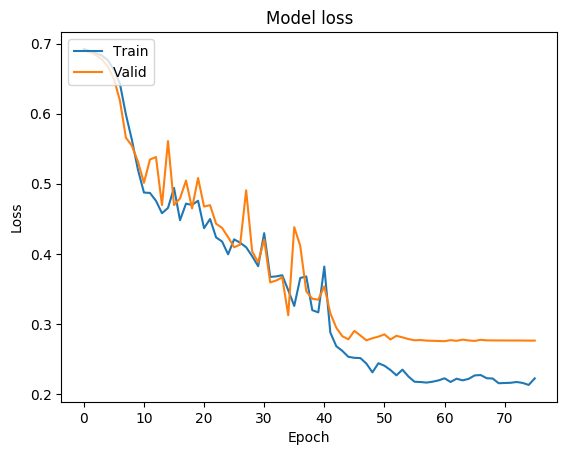

In [0]:
# show loss
visualization.visualize_loss(history)

In [0]:
# save model manually
path = datetime_train + '.h5'
cnn_classifier.save(path)

## [Optional] Copy logs folder

In [0]:
# copy logs dir directly to google drive

import shutil

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.exists(d):
          continue
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
            
src = LOGS_DIR
dst = os.path.join(DISSERTATION_DIR, 'logs', trainer)
copytree(src, dst)

In [0]:
# save weight only
path = datetime_train + '_weights' + '.h5'
cnn_classifier.save_weights(path)